# Wavefield Separation FWI sensitivity kernel
We compare sensitivity kernels in a half-space model with wavefield separation imaging conditions. Wavefield separation in the imaging condition can both enhance long wavelength FWI gradients (for FWI), and remove long wavelength backscattered energy (for RTM) and is implemented as a wavenumber filter in Kz following Faqi et. al. (2011).

### Workflow for the standard FWI imaging condition
The standard imaging condition will have short wavelengths in the FWI image, and also long wavelengths in the RTM image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Zero lag correlation of forward source wavefield `S` with backward receiver wavefield `R` at every time step in the model: `Image += S * R`

### Workflow for the wavefield separation FWI imaging condition
This will enhance long wavelengths in the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation `Image += Sup * Rup + Sdn * Rdn`

### Workflow for the wavefield separation RTM imaging condition
This will remove long wavelength backscattered energy from the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in water velocity model
1. Subtracting water velocity data from true data to remove direct arrival
1. Backproject the direct arrival removed true data
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation `Image += Sup * Rdn + Sdn * Rup`

### Reference
* *An effective imaging condition for reverse-time migration using wavefield decomposition* 2011<br>
Faqi Liu, Guanquan Zhang, Scott A. Morton, and Jacques P. Leveille
https://library.seg.org/doi/full/10.1190/1.3533914

In [21]:
using PyPlot, Jets, WaveFD, JetPackWaveFD, Random, LinearAlgebra

## Make three models
* true halfspace model with velocities 1500 m/s over 2000 m/s
* perturbed halfspace model with velocities 1505 m/s over 2000 m/s
* water velocity model at 1500 m/s

We make the perturbed model slightly faster in the upper half-space, which indicates that the gradients for FWI should be all positive.

In [22]:
nz,nx = 150,600
dz,dx = 20.0,20.0
z2 = 101

vtrue = 1500 .* ones(Float32,nz,nx);
vtrue[z2:end,:] .= 2000;

vpert = 1510 .* ones(Float32,nz,nx);
vpert[z2:end,:] .= 2000;

vwater = 1500 .* ones(Float32,nz,nx);

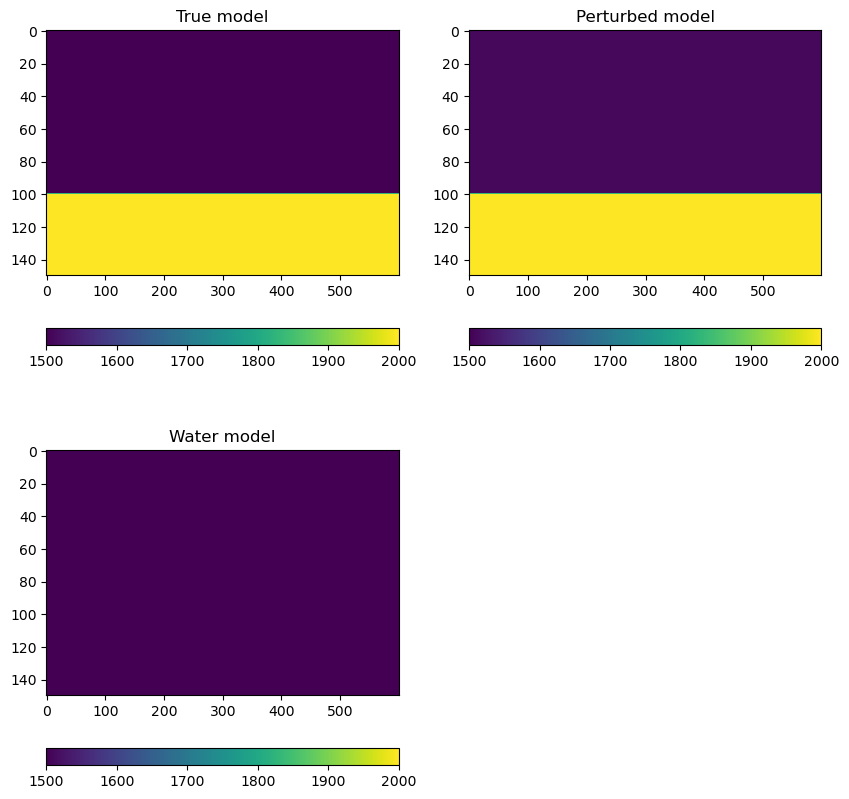

In [23]:
figure(figsize=(10,10))
vmin,vmax = extrema(vtrue)
subplot(2,2,1);imshow(vtrue,aspect="auto"); title("True model"); clim(vmin,vmax);
colorbar(orientation="horizontal")
subplot(2,2,2);imshow(vpert,aspect="auto"); title("Perturbed model"); clim(vmin,vmax)
colorbar(orientation="horizontal");
subplot(2,2,3);imshow(vwater,aspect="auto"); title("Water model"); clim(vmin,vmax)
colorbar(orientation="horizontal");

## Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [24]:
scratch = "/mnt/scratch"
@assert isdir(scratch)

## Make three operators
* Standard imaging condition 
* FWI imaging condition 
* RTM imaging condition 

In [25]:
ntrec = 2001
dtrec = 0.004
dtmod = 0.002

sz = dz * 1;
sx = dx * div(nx,2);
rz = dz .* ones(Float32, nx);
rx = dx .* Float32[0:(nx-1);];

Fstd = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=5000, imgcondition = "standard");

Ffwi = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=5000, imgcondition = "FWI");

Frtm = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,size(vtrue)),
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=5000, imgcondition = "RTM");

## Forward modeling
Generate data to be backprojected:
* FWI: backproject (d_pert - d_true)
* RTM: backproject (d_true - d_water)

In [26]:
dtrue = Fstd*vtrue;
dpert = Fstd*vpert;
dwater = Fstd*vwater;

rfwi = dpert .- dtrue
rrtm = dtrue .- dwater

@show extrema(dtrue)
@show extrema(dpert)
@show extrema(dwater)
@show extrema(rfwi)
@show extrema(rrtm)
nothing

┌ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-sJFyWIKM.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:398
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  4001 of  4001  187.38 MCells/s (IO=41.01, EX=48.74, PR= 9.47) -- rms d,p; 1.5520e+00 2.3077e-03
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:738
┌ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-sJFyWIKM.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:398
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  4001 of  4001  181.53 MCells/s (IO=39.40, EX=47.27, PR=12.10) -- rms d,p; 1.5567e+00 2.3341e-03
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:738
┌ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-sJFyWIKM.bin
└ @ JetPackWaveFD /home/cvx/.jul

extrema(dtrue) = (-87.961914f0, 168.83282f0)
extrema(dpert) = (-88.11172f0, 169.16418f0)
extrema(dwater) = (-87.961914f0, 168.83282f0)
extrema(rfwi) = (-2.534933f0, 2.966783f0)


┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  4001 of  4001  193.83 MCells/s (IO=43.01, EX=46.36, PR= 9.79) -- rms d,p; 1.5440e+00 1.5524e-03
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:738


extrema(rrtm) = (-1.5591953f0, 3.247685f0)


## Plot the generated data

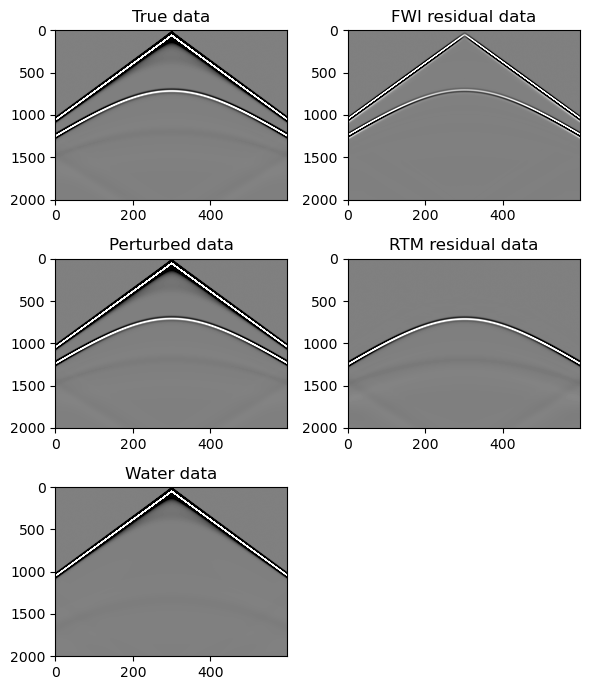

scale = 1.610867258181568


In [27]:
scale = 2.5 / sqrt(norm(dtrue)^2 / length(dtrue))
@show scale

figure(figsize=(6,7)); clf()
subplot(3,2,1); imshow(scale .* dtrue,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("True data")
subplot(3,2,2); imshow(scale .* rfwi,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("FWI residual data")
subplot(3,2,3); imshow(scale .* dpert,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Perturbed data")
subplot(3,2,4); imshow(scale .* rrtm,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("RTM residual data")
subplot(3,2,5); imshow(scale .* dwater,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Water data")
tight_layout()
nothing

## Apply the three imaging conditions

In [28]:
Jstd = jacobian!(Fstd, vpert)
Jfwi = jacobian!(Ffwi, vpert)
Jrtm = jacobian!(Frtm, vpert)

fwi1 = Jstd' * rfwi;
fwi2 = Jfwi' * rfwi;
rtm1 = Jstd' * rrtm;
rtm2 = Jrtm' * rrtm;

@show extrema(fwi1)
@show extrema(fwi2)
@show extrema(rtm1)
@show extrema(rtm2)
nothing

┌ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-sJFyWIKM.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:398
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  4001 of  4001  227.99 MCells/s (IO=50.79, EX=35.66, PR=12.60) -- rms d,p; 0.0000e+00 2.3341e-03
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:738
┌ Info: linear adjoint on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-sJFyWIKM.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:647
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  4001    0.00 MCells/s (IO= 0.00, EX= 0.00, IM= 0.00, PR= 0.00) -- rms d,p; 1.3644e-01 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:725
┌ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-reljwfmG.bin
└ @ JetPackWaveFD /home/cvx/.julia/

extrema(fwi1) = (-1.2226564f0, 6.6873536f0)
extrema(fwi2) = (-0.024563404f0, 1.8252447f0)
extrema(rtm1) = (-1.3714867f0, 0.15710525f0)
extrema(rtm2) = (-0.30952638f0, 0.057641692f0)


## Zero pixels in the images that are close to the source

In [29]:
nzero = 5

fwi1[1:nzero,:] .= 0;
fwi2[1:nzero,:] .= 0;
rtm1[1:nzero,:] .= 0;
rtm2[1:nzero,:] .= 0;
nothing

## Plot the results
* Because in the perturbed model the upper half-space is faster, we expect the gradient to be positive (red). 
* Note how the FWI wavefield separation enhances long wavelengths
* Note how the RTM wavefield separation removes long wavelength backscattered energy

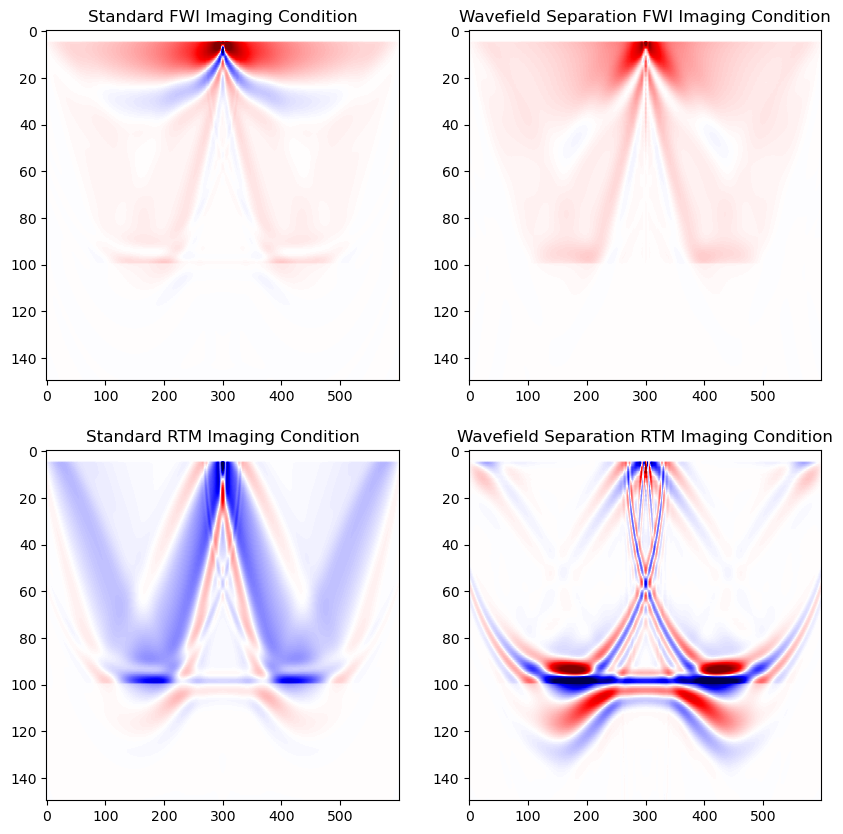

In [30]:
figure(figsize=(10,10))
scale = 2
subplot(2,2,1); imshow(fwi1.*scale/maximum(abs,fwi1),aspect="auto",cmap="seismic",clim=[-1,1]);
title("Standard FWI IC")
subplot(2,2,2); imshow(fwi2.*scale/maximum(abs,fwi2),aspect="auto",cmap="seismic",clim=[-1,1]);
title("Wavefield Separation FWI IC")
subplot(2,2,3); imshow(rtm1.*scale/maximum(abs,rtm1),aspect="auto",cmap="seismic",clim=[-1,1]);
title("Standard RTM IC")
subplot(2,2,4); imshow(rtm2.*scale/maximum(abs,rtm2),aspect="auto",cmap="seismic",clim=[-1,1]);
title("Wavefield Separation RTM IC")
nothing